In [1]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import metpy
import scipy.stats as sts
import re
from glob import glob
import warnings
import isca_tools
from isca_tools import cesm
from isca_tools.convection import dry_profile_temp, potential_temp
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils.base import weighted_RMS
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, lapse_moist, moist_profile
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure, \
    get_var_at_plev, get_ds_in_pressure_range
from isca_tools.utils.moist_physics import sphum_sat, moist_static_energy
from isca_tools.thesis.adiabat_theory2 import get_scale_factor_theory_numerical, get_temp_adiabat_surf
from isca_tools.thesis.profile_fitting import get_mse_env, get_tropopause_lev_ind, get_mse_prof_rms
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
from typing import Tuple, Optional
import os
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7

plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

In [3]:
from jobs.theory_lapse.scripts.lcl import ds, ds_lcl, find_lcl_empirical2

2025-10-21 08:47:57 - Start
2025-10-21 08:48:08 - Loaded in Data
2025-10-21 08:48:22 - Added variables for LCL computation
2025-10-21 08:48:22 - LCL Info loaded from ds_lcl.nc files
2025-10-21 08:48:22 - End


## Empirical LCL Computation
Below I show a step by step example of how I compute the empirical LCL for a specific location.

In [4]:
# ds_use = ds.sel(lat=3, lon=15, method='nearest')        # Congo
ds_use = ds.sel(lat=-14.6, lon=320, method='nearest')  # Amazon 2
# ds_use = ds.sel(lat=35, lon=100, method='nearest')       # Tibet
ds_use = ds.sel(lat=55, lon=290, method='nearest')      # Large inversion
# ds_use = ds.sel(lat=-85, lon=100, method='nearest')     # Antarctica
# ds_use = ds.sel(lat=25, lon=50,method='nearest')        # Pursian gulf
# ds_use = ds.sel(lat=28, lon=50, method='nearest')       # Pursian gulf coastline
# ds_use = ds.sel(lat=18, lon=0,method='nearest')         # Sahara
# ds_use = ds.sel(lat=30, lon=180, method='nearest')      # Ocean
# ds_use = ds.sel(lat=53, lon=100, method='nearest')  # Canada
ds_use = ds_use.isel(co2=0, sample=0)
small = 1
use_lev = ds_use.P >= ds_use.P.isel(lev=ds_use.lnb_ind) - small

In [5]:
# Physical LCL
ds_use['p_lcl'], ds_use['T_lcl'] = lcl_metpy(ds_use.TREFHT, ds_use.QREFHT, ds_use.PREFHT)
ds_use['Z_at_lcl'] = get_var_at_plev(ds_use.Z3, ds_use.P, ds_use.p_lcl)
ds_use['T_at_lcl'] = get_var_at_plev(ds_use.T, ds_use.P, ds_use.p_lcl)

In [6]:
# Compute previous LCL empirical method
ds_use['p_lcl_emp2'], ds_use['T_lcl_emp2'] = find_lcl_empirical2(ds_use.T, ds_use.P, ds_use.Z3, ds_use.TREFHT, ds_use.PREFHT)
ds_use['Z_at_lcl_emp2'] = get_var_at_plev(ds_use.Z3, ds_use.P, ds_use.p_lcl_emp2)
ds_use['T_at_lcl_emp2'] = get_var_at_plev(ds_use.T, ds_use.P, ds_use.p_lcl_emp2)

In [7]:
# Find model level that is best LCL
error_rms_lev = get_mse_prof_rms(ds_use.T.where(use_lev), ds_use.P.where(use_lev), ds_use.Z3.where(use_lev), ds_use.P_diff.where(use_lev))
lcl_lev_ind = error_rms_lev.argmin(dim='lev')

# Build a fine grid of n_split pressure levels around best LCL model level
n_split = 20
pressure_min = ds_use.P.isel(lev=np.clip(lcl_lev_ind-1, 0, ds.lev.size-1))
pressure_max = ds_use.P.isel(lev=np.clip(lcl_lev_ind+1, 0, ds.lev.size-1))
ds_split = get_ds_in_pressure_range(ds_use[['T', 'Z3', 'P']], pressure_min, pressure_max, n_split,
                                    pressure_dim_name_out='lev_fine_ind')

# On this fine grid, repeat RMS error of MSE profile calculation - select min error as the LCL
ds_split['error_rms'] = get_mse_prof_rms(ds_use.T.where(use_lev), ds_use.P.where(use_lev), ds_use.Z3.where(use_lev),
                                  ds_use.P_diff.where(use_lev), ds_split.T, ds_split.P, ds_split.Z3, split_dim='lev_fine_ind')
ds_use['p_lcl_emp'] = ds_split.P.isel(lev_fine_ind=ds_split['error_rms'].argmin(dim='lev_fine_ind'))
ds_use['error_rms_emp'] = ds_split['error_rms'].min(dim='lev_fine_ind')
ds_use['T_lcl_emp'] = dry_profile_temp(ds_use.TREFHT, ds_use.PREFHT, ds_use.p_lcl_emp)
ds_use['T_at_lcl_emp'] = get_var_at_plev(ds_use.T, ds_use.P, ds_use.p_lcl_emp)
ds_use['Z_at_lcl_emp'] = get_var_at_plev(ds_use.Z3, ds_use.P, ds_use.p_lcl_emp)

In [8]:
if 'sample' in ds_use.dims:
    ind_emp = np.abs(ds_use.p_lcl - ds_use.p_lcl_emp2).argmax()
    print(f'Emp2 | Sample {ind_emp} | {(ds_use.p_lcl - ds_use.p_lcl_emp2).isel(sample=ind_emp)/100:.0f}')
    ind_emp = np.abs(ds_use.p_lcl - ds_use.p_lcl_emp).argmax()
    print(f'Emp | Sample {int(ind_emp)} | {(ds_use.p_lcl - ds_use.p_lcl_emp).isel(sample=ind_emp)/100:.0f}')

In [9]:
# Compute RMS error around physical LCL
p_range = float(ds_split.P[-1] - ds_split.P[0])
ds_split_phys = get_ds_in_pressure_range(ds_use[['T', 'Z3', 'P']], ds_use.p_lcl-p_range/2, ds_use.p_lcl+p_range/2, n_pressure=n_split,
                                         pressure_dim_name_out='lev_fine_ind')
ds_split_phys['error_rms'] = get_mse_prof_rms(ds_use.T.where(use_lev), ds_use.P.where(use_lev), ds_use.Z3.where(use_lev),
                                              ds_use.P_diff.where(use_lev), ds_split_phys.T, ds_split_phys.P, ds_split_phys.Z3, split_dim='lev_fine_ind')

In [10]:
# Compute RMS error at physical LCL
ds_rms = get_ds_in_pressure_range(ds_use[['T', 'Z3', 'P']], ds_use.p_lcl, ds_use.p_lcl + small, n_pressure=1,
                                  pressure_dim_name_out='lev_fine_ind')
ds_rms['error_rms'] = get_mse_prof_rms(ds_use.T.where(use_lev), ds_use.P.where(use_lev), ds_use.Z3.where(use_lev),
                                       ds_use.P_diff.where(use_lev), ds_rms.T, ds_rms.P, ds_rms.Z3, split_dim='lev_fine_ind')
ds_use['error_rms_phys'] = ds_rms['error_rms'].min(dim='lev_fine_ind')

In [11]:
# Compute RMS error at empirical LCL 2
ds_rms = get_ds_in_pressure_range(ds_use[['T', 'Z3', 'P']], ds_use.p_lcl_emp2, ds_use.p_lcl_emp2 + small, n_pressure=1,
                                  pressure_dim_name_out='lev_fine_ind')
ds_rms['error_rms'] = get_mse_prof_rms(ds_use.T.where(use_lev), ds_use.P.where(use_lev), ds_use.Z3.where(use_lev),
                                       ds_use.P_diff.where(use_lev), ds_rms.T, ds_rms.P, ds_rms.Z3, split_dim='lev_fine_ind')
ds_use['error_rms_emp2'] = ds_rms['error_rms'].min(dim='lev_fine_ind')

In [12]:
ds_use['lapse_rate'] = -ds_use.T.diff(dim='lev', label='upper') / ds_use.Z3.diff(dim='lev', label='upper') * 1000
ds_use['mse_sat'] = moist_static_energy(ds_use.T, sphum_sat(ds_use.T, ds_use.P), ds_use.Z3)

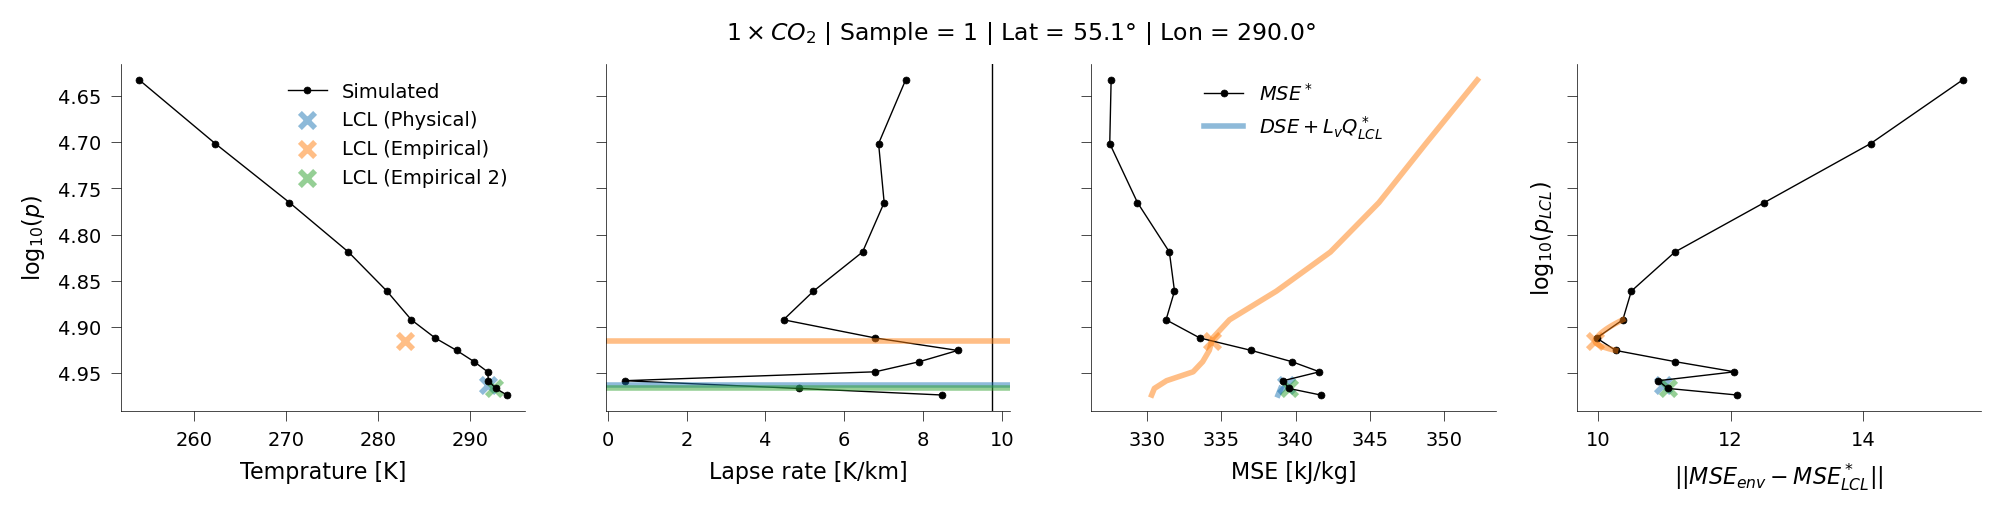

In [14]:
plot_lev = use_lev      # below LNB
plot_lev = np.log10(ds_use.P) > 4.6


fig, ax = plt.subplots(1, 4, sharey=True)
fig_resize(fig, 12)
ax[0].plot(ds_use.T.where(plot_lev), np.log10(ds_use.P).where(plot_lev), marker='o', color='k',
           label='Simulated')
ax[0].scatter(ds_use.T_lcl, np.log10(ds_use.p_lcl), marker='x', s=30, lw=2, color='C0', label='LCL (Physical)', alpha=0.5)
ax[0].scatter(ds_use.T_lcl_emp, np.log10(ds_use.p_lcl_emp), marker='x', s=30, lw=2, color='C1', label='LCL (Empirical)', alpha=0.5)
ax[0].scatter(ds_use.T_lcl_emp2, np.log10(ds_use.p_lcl_emp2), marker='x', s=30, lw=2, color='C2', label='LCL (Empirical 2)', alpha=0.5)


x_var = ds_use['lapse_rate'].where(plot_lev.isel(lev=slice(1, 999999)))
y_var = np.log10(ds_use.P).isel(lev=slice(1, 999999)).where(plot_lev.isel(lev=slice(1, 999999)))
ax[1].plot(x_var, y_var, marker='o', color='k')
ax[1].axvline(lapse_dry * 1000, color='k')
ax[1].axhline(np.log10(ds_use.p_lcl), color='C0', lw=2, alpha=0.5)
ax[1].axhline(np.log10(ds_use.p_lcl_emp), color='C1', lw=2, alpha=0.5)
ax[1].axhline(np.log10(ds_use.p_lcl_emp2), color='C2', lw=2, alpha=0.5)


ax[2].plot(ds_use.mse_sat.where(plot_lev), np.log10(ds_use.P).where(plot_lev), marker='o', color='k',
            label='$MSE^*$')
ax[2].plot(get_mse_env(ds_use.T, ds_use.P, ds_use.Z3, ds_use.T_at_lcl, ds_use.p_lcl, 'below_lcl').where(ds_use.P>=ds_use.p_lcl),
           np.log10(ds_use.P).where(ds_use.P>=ds_use.p_lcl), color='C0', lw=2, alpha=0.5, label='$DSE + L_v Q^*_{LCL}$')
ax[2].plot(get_mse_env(ds_use.T, ds_use.P, ds_use.Z3, ds_use.T_at_lcl_emp, ds_use.p_lcl_emp, 'below_lcl').where(plot_lev),
           np.log10(ds_use.P).where(plot_lev), color='C1', lw=2, alpha=0.5)
ax[2].plot(get_mse_env(ds_use.T, ds_use.P, ds_use.Z3, ds_use.T_at_lcl_emp2, ds_use.p_lcl_emp2, 'below_lcl').where(ds_use.P>=ds_use.p_lcl_emp2),
           np.log10(ds_use.P).where(ds_use.P>=ds_use.p_lcl_emp2), color='C2', lw=2, alpha=0.5)
ax[2].scatter(moist_static_energy(ds_use.T_at_lcl, sphum_sat(ds_use.T_at_lcl, ds_use.p_lcl), ds_use.Z_at_lcl),
              np.log10(ds_use.p_lcl), marker='x', s=30, lw=2, color='C0', alpha=0.5)
ax[2].scatter(moist_static_energy(ds_use.T_at_lcl_emp, sphum_sat(ds_use.T_at_lcl_emp, ds_use.p_lcl_emp), ds_use.Z_at_lcl_emp),
              np.log10(ds_use.p_lcl_emp), marker='x', s=30, lw=2, color='C1', alpha=0.5)
ax[2].scatter(moist_static_energy(ds_use.T_at_lcl_emp2, sphum_sat(ds_use.T_at_lcl_emp2, ds_use.p_lcl_emp2), ds_use.Z_at_lcl_emp2),
              np.log10(ds_use.p_lcl_emp2), marker='x', s=30, lw=2, color='C2', alpha=0.5)


ax[3].plot(error_rms_lev.where(plot_lev), np.log10(ds_use.P).where(plot_lev), marker='o', color='k')
if np.abs(np.log10(ds_use.p_lcl) - np.log10(ds_use.p_lcl_emp)) > 0.1:
    ax[3].plot(ds_split_phys['error_rms'], np.log10(ds_split_phys.P), color='C0', lw=2, alpha=0.5)
ax[3].plot(ds_split['error_rms'], np.log10(ds_split.P), color='C1', lw=2, alpha=0.5)
ax[3].scatter(ds_use.error_rms_phys,
              np.log10(ds_use.p_lcl), marker='x', s=30, lw=2, color='C0', alpha=0.5)
ax[3].scatter(ds_use.error_rms_emp,
              np.log10(ds_use.p_lcl_emp), marker='x', s=30, lw=2, color='C1', alpha=0.5)
ax[3].scatter(ds_use.error_rms_emp2,
              np.log10(ds_use.p_lcl_emp2), marker='x', s=30, lw=2, color='C2', alpha=0.5)


ax[0].invert_yaxis()
ax[0].set_ylabel('$\log_{10}(p)$')
ax[0].set_xlabel('Temprature [K]')
ax[1].set_xlabel('Lapse rate [K/km]')
ax[2].set_xlabel('MSE [kJ/kg]')
ax[3].set_xlabel('$||MSE_{env} - MSE_{LCL}^*||$')
ax[3].set_ylabel('$\log_{10}(p_{LCL})$')
ax[0].legend()
ax[2].legend()
# ax[2].set_xlim(325, 340)
fig.suptitle(
    f"${int(ds_use.co2)} \\times CO_2$ | Sample = {int(ds_use.sample)} | Lat = {ds_use.lat:.1f}$\degree$ | Lon = {ds_use.lon:.1f}$\degree$",
    fontsize=8.5)
plt.show()

In [16]:
%%time
ds_lcl['p_lcl_emp2'] = find_lcl_empirical2(ds.T, ds.P, ds.Z3, ds.TREFHT, ds.PREFHT)[0]

CPU times: user 1.79 s, sys: 1.85 s, total: 3.63 s
Wall time: 4.61 s


In [18]:
# Land masks
invariant_data_path = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/input_data/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc'
lsm = (xr.open_dataset(invariant_data_path).LANDFRAC > 0)
lsm = lsm.reindex_like(ds, method="nearest", tolerance=0.01)

In [19]:
def initialize_ax_projection(ax, lon_min=-180, lon_max=180, lat_min=30, lat_max=80,
                             grid_lon=np.arange(-180, 180.01, 60), grid_lat=np.asarray([-30, 30])):
    ax.coastlines(color='k', linewidth=1)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    gl = ax.gridlines(ccrs.PlateCarree(), xlocs=grid_lon, ylocs=grid_lat, linestyle=':',
                      color='k', alpha=1, draw_labels=True)
    gl.right_labels = 0
    gl.top_labels = 0
    return ax


def plot_contour_projection(ax, var, levels=None, n_levels=10, mask=lsm, cmap='viridis'):
    data, lon = add_cyclic_point(var if mask is None else var.where(mask), coord=var.lon.values, axis=1)
    if levels is None:
        levels = np.linspace(var.min(), var.max(), n_levels)
    im = ax.contourf(lon, var.lat.values, data, transform=ccrs.PlateCarree(),
                     levels=levels, extend='both', cmap=cmap)
    return im

## Spatial distribution of LCL
Below I plot how the different estimates of the LCL vary spatially. I also plot the RMS error in the MSE profile. The Empirical method LCL is found by minimizing this quantity.

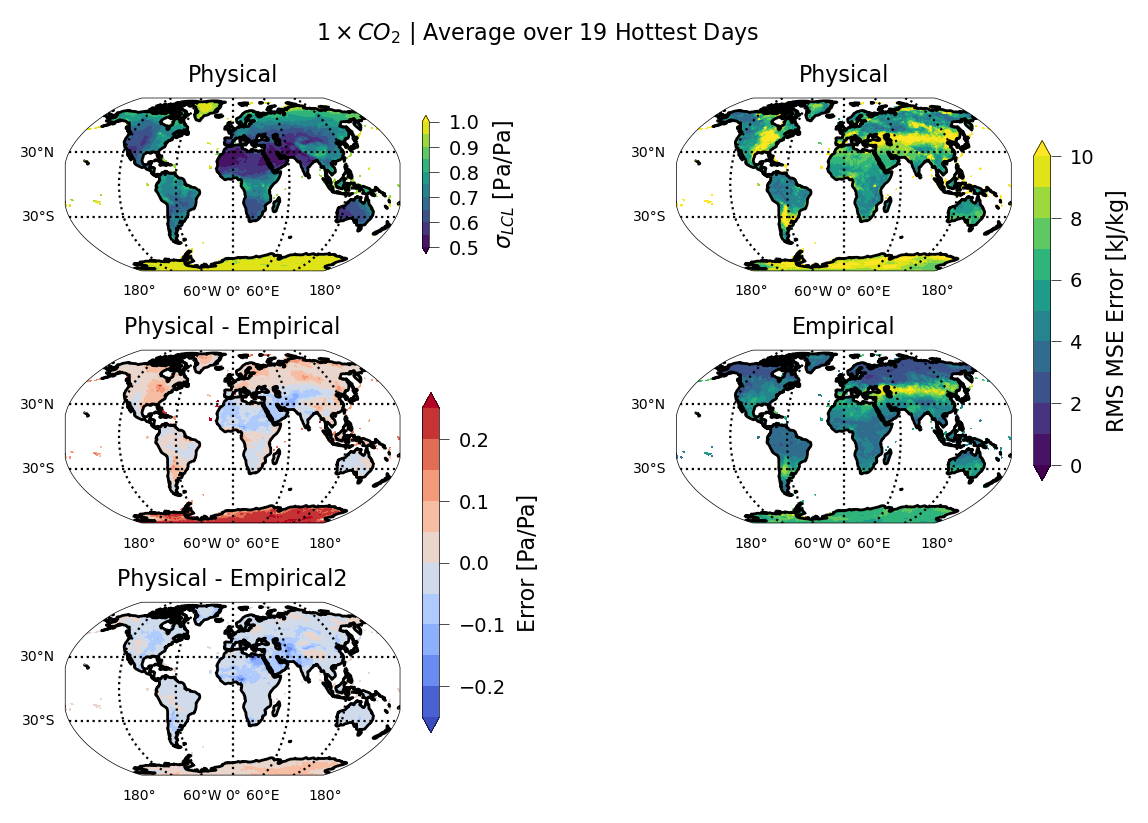

In [45]:
lat_plot_min = -90
lat_plot_max = 90

co2_ind = 0
fig = plt.figure(constrained_layout=True, figsize=(6, 4))
ax = fig.subplots(3, 2, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
fig.delaxes(ax[2, 1])
for ax_use in ax.flatten():
    initialize_ax_projection(ax_use, lat_min=lat_plot_min, lat_max=lat_plot_max)
fig.suptitle(f'${int(ds.co2.values[co2_ind])} \\times CO_2$ | Average over {ds_lcl.sample.size} Hottest Days', fontsize=8)

# Plot LCL Sigma levels
levels_use = np.arange(0.5, 1.05, 0.05)
im = plot_contour_projection(ax[0, 0], (ds_lcl['p_lcl'] / ds.PREFHT).isel(co2=co2_ind).mean(dim='sample'), cmap='viridis',
                             levels=levels_use)
fig.colorbar(shrink=0.8, ax=ax[0, 0], label='$\sigma_{LCL}$ [Pa/Pa]', mappable=im)
ax[0, 0].set_title('Physical')

levels_use=np.arange(-0.25, 0.3, 0.05)
im = plot_contour_projection(ax[1, 0], ((ds_lcl['p_lcl'] - ds_lcl['p_lcl_emp']) / ds.PREFHT).isel(co2=co2_ind).mean(dim='sample'),
                             cmap='coolwarm', levels=levels_use)
ax[1, 0].set_title('Physical - Empirical')

im = plot_contour_projection(ax[2, 0], ((ds_lcl['p_lcl'] - ds_lcl['p_lcl_emp2']) / ds.PREFHT).isel(co2=co2_ind).mean(dim='sample'),
                             cmap='coolwarm', levels=levels_use)
fig.colorbar(shrink=0.8, ax=ax[1:, 0].ravel(), label='Error [Pa/Pa]', mappable=im)
ax[2, 0].set_title('Physical - Empirical2')


# Plot RMS error
levels_use = np.arange(0, ds_lcl.error_rms_emp.quantile(0.95), 1)
im = plot_contour_projection(ax[0, 1], ds_lcl.error_rms.isel(co2=co2_ind).mean(dim='sample'), cmap='viridis',
                             levels=levels_use)
ax[0, 1].set_title('Physical')
im = plot_contour_projection(ax[1, 1], ds_lcl.error_rms_emp.isel(co2=co2_ind).mean(dim='sample'), cmap='viridis',
                             levels=levels_use)
ax[1, 1].set_title('Empirical')
fig.colorbar(shrink=0.8, ax=ax[:2, 1].ravel(), label='RMS MSE Error [kJ/kg]', mappable=im)
# isca_tools.savefig(fig)
plt.show()